In [1]:
import numpy as np 
import pandas as pd 
import pickle

# visualizatioion pkg 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format='retina'

import sys
sys.path.append('..')

from utils.viz import viz 
from utils.model import *  
from utils.fig_fn import *
viz.get_style()

In [2]:
data_set = 'exp2'
dpi = 300
to_pdf = True

In [3]:
def analyze_ecPG_fea(lmbdas = [0, .07, .1, .2, .5]):
    all_sim_data = []
    all_gen_data = []
    agent = 'ecPG_fea_sim'
    exp = 'exp2'
    lmbdas2 = [0, .2]
    psi, rho = 11, 4
    block_types = ['cons', 'cont', 'conf']
    block_names = ['Consistent', 'Control', 'Conflict']
    for lmbda in lmbdas:

        for block_type in block_types:
        
            # transfer performance
            fname  = f'../simulations/{exp}/{agent}/simsubj-{block_type}_data'
            fname += f'-alpha_psi={psi}-alpha_rho={rho}-lmbda={lmbda}.csv'
            sim_data = pd.read_csv(fname)
            gen_data = sim_data.query('stage=="test"').copy()
            gen_data['lmbda'] = str(lmbda)
            gen_data['block_type'] = block_type
            all_gen_data.append(gen_data)

            # complexity 
            sel_data = sim_data.query('stage=="train"').groupby(by=['trial']
                            ).mean(numeric_only=True).reset_index()
            sel_data['i_SZ'] = sel_data['i_SZ'].apply(lambda x: x/np.log(2))
            sel_data['lmbda'] = str(lmbda)
            sel_data['block_type'] = block_type
            all_sim_data.append(sel_data)

            # attention 
            fname = f'../simulations/{exp}/{agent}/simsubj-{block_type}_voi'
            fname += f'-alpha_psi={psi}-alpha_rho={rho}-lmbda={lmbda}.pkl'
            with open(fname, 'rb')as handle:
                voi = pickle.load(handle)
        
    all_sim_data = pd.concat(all_sim_data, axis=0).groupby(
        by=['lmbda', 'block_type', 'trial'])['i_SZ'].mean().reset_index()
    all_gen_data = pd.concat(all_gen_data, axis=0).groupby(
        by=['lmbda', 'untrained', 'block_type'])['r'].mean().reset_index()

    all_attn_data = []
    for lmbda in lmbdas2:
        for block_type in block_types:
            # load data 
            fname = f'../simulations/{exp}/{agent}/simsubj-{block_type}_voi'
            fname += f'-alpha_psi={psi}-alpha_rho={rho}-lmbda={lmbda}.pkl'
            with open(fname, 'rb')as handle:
                voi = pickle.load(handle)
            attn = np.hstack(voi['attn'])
            trial = np.repeat(np.arange(60), 3)
            feature = np.tile(['shape', 'color', 'aggendage'], 60)
            attn_data = pd.DataFrame.from_dict({
                'importance': attn,
                'trial': trial,
                'feature': feature, 
            })
            attn_data['block_type'] = block_type
            attn_data['lmbda'] = lmbda
            all_attn_data.append(attn_data)
    all_attn_data = pd.concat(all_attn_data, axis=0)

    fig, axs = plt.subplots(4, 3, figsize=(8.5, 8.5))
    for i, block_type in enumerate(block_types):
        ax=axs[3, i]
        sns.barplot(x='untrained', y='r', data=all_gen_data.query(f'block_type=="{block_type}"'),
                    lw=.75, edgecolor=viz.lmbda_gradient[4],
                    #legend=False,
                    hue='lmbda',
                    palette=viz.lmbda_gradient,
                    alpha=.8,
                    ax=ax)
        ax.legend().remove()
        ax.axhline(y=.5, xmin=0, xmax=1, ls='--', lw=1, color='k')
        for pos in ['bottom', 'left']: ax.spines[pos].set_linewidth(2.75)

        ax.set_xticks([0, 1])
        ax.set_xticklabels(['Trained', 'Untrained'])
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('')
        ax.set_box_aspect(.85)
        ax = axs[2, i]
        sns.lineplot(x='trial', y='i_SZ', data=all_sim_data.query(f'block_type=="{block_type}"'),
                    lw=4.5,
                    legend=False,
                    hue='lmbda',
                    palette=viz.lmbda_gradient,
                    alpha=.8,
                    ax=ax)
        sns.lineplot(x='trial', y='i_SZ', data=all_sim_data.query(f'lmbda=="0.1"&block_type=="{block_type}"'),
                    lw=7.5,
                    legend=False,
                    #hue='lmbda',
                    color=viz.lmbda_gradient[2],
                    alpha=.8,
                    ax=ax)
        
        for pos in ['bottom', 'left']: ax.spines[pos].set_linewidth(2.75)
        ax.set_xticks([0, 30, 60])
        ax.set_ylabel('Represenation \ncomplexity (bits)')
        ax.set_xlabel('Trials')
        ax.set_box_aspect(.85)

    for j, lmbda in enumerate(lmbdas2):
        for i, block_type in enumerate(block_types):
            ax = axs[j, i]
            sns.lineplot(x='trial', y='importance', 
                        data=all_attn_data.query(
                            f'block_type=="{block_type}"&lmbda=={lmbda}'
                        ),
                        hue='feature', hue_order=['shape', 'color', 'appendage'],
                        lw=6,
                        palette=viz.Pal_fea,
                        legend=False, 
                        ax=ax)
            sns.lineplot(x='trial', y='importance', 
                        data=all_attn_data.query(
                            f'block_type=="{block_type}"&lmbda=={lmbda}&feature=="shape"'
                            ),
                        lw=3,
                        color=viz.Pal_fea[2],
                        legend=False, 
                        zorder=100,
                        ax=ax)
            if j==0: ax.set_title(f'{block_names[i]}')
            ax.set_ylim([-.1, 1.1])
            ax.set_xticks([0, 20, 40, 60])
            ax.set_yticks([0, .5, 1])
            ax.set_xlabel('Trials')
            ax.set_ylabel('Importance \n (a.u.)') 
            ax.set_box_aspect(.45)
            ax.yaxis.set_tick_params(labelleft=True)
            ax.spines['left'].set_position(('axes',-0.05))
            for pos in ['bottom', 'left']: ax.spines[pos].set_linewidth(2.5)
    fig.tight_layout()

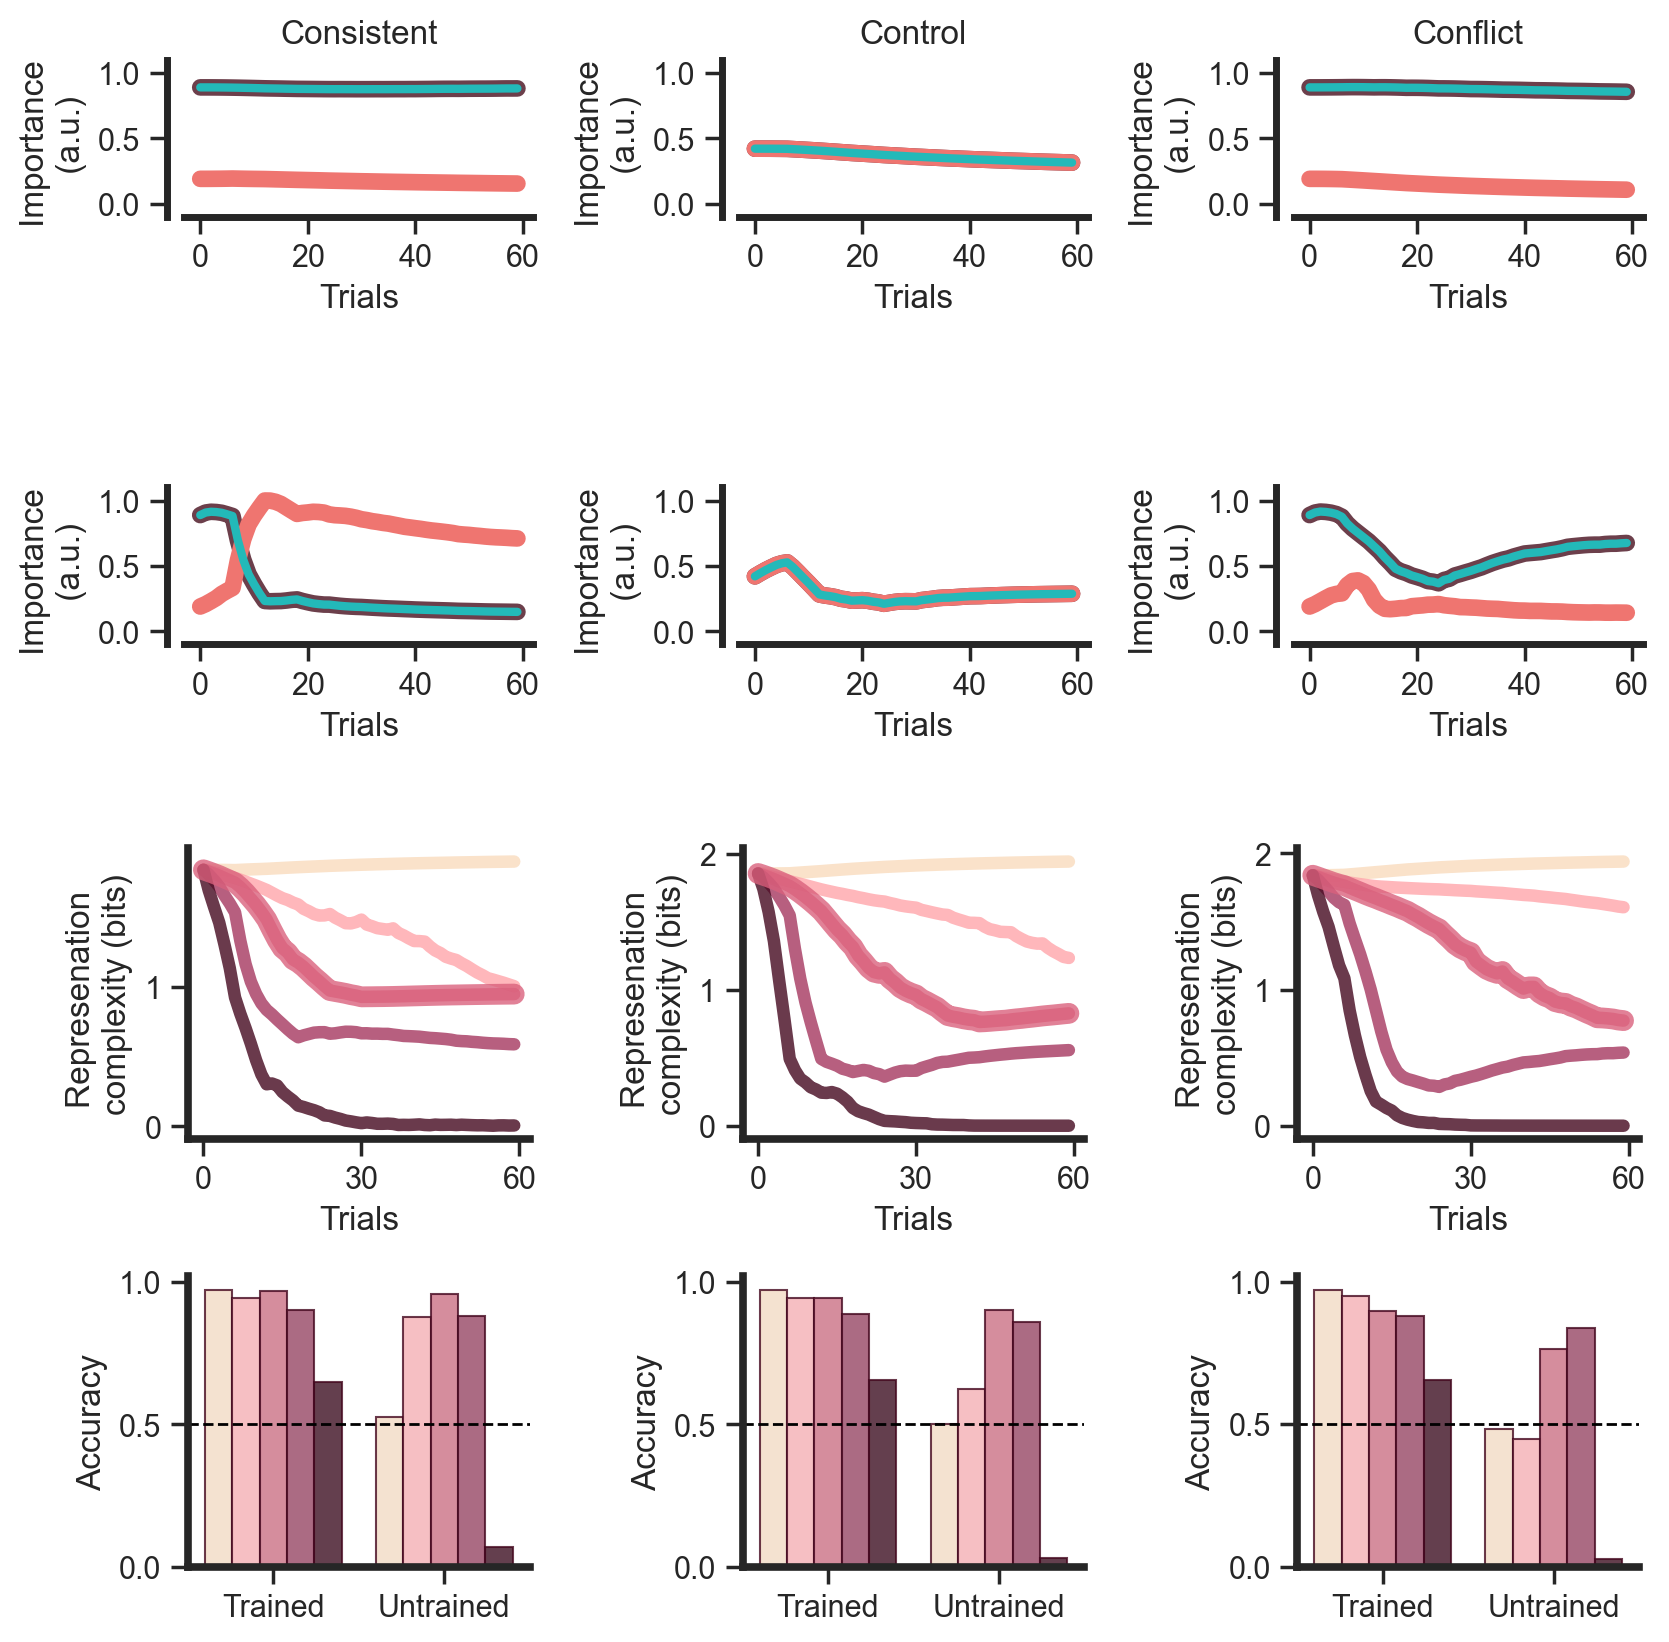

In [4]:
analyze_ecPG_fea(lmbdas=[0, .07, .1, .2, .5])
if to_pdf: plt.savefig(f'../figures/{data_set}/Fig6ABCD_sim_info.pdf', dpi=dpi)

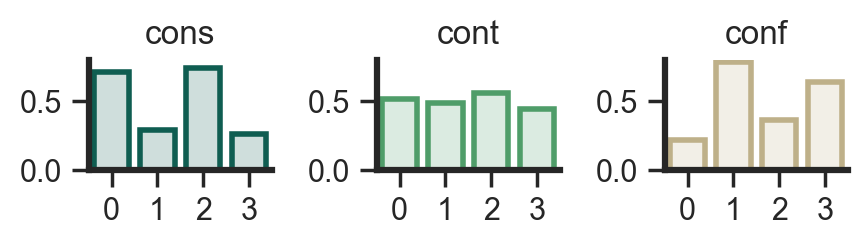

In [5]:
def sim_probe_bar(exp, agent_name, block_types):
    voi = {}
    for block_type in block_types:
        psi, rho, lmbda = 11, 4, .1
        fname = f'../simulations/{exp}/{agent_name}/simsubj-{block_type}_voi'
        fname += f'-alpha_psi={psi}-alpha_rho={rho}-lmbda={lmbda}.pkl'
        with open(fname, 'rb')as handle: voi[block_type] = pickle.load(handle)
    nr, nc = 1, len(block_types)
    fig, axs = plt.subplots(nr, nc, figsize=(4.5, 1.5))
    for b, block_type in enumerate(block_types):
        ax = axs[b]
        pol = voi[block_type]['pol'][59][4, :]
        sns.barplot(x=[0, 1, 2, 3], y=pol,
                        errorbar='se', linewidth=2, width=.75,
                        edgecolor=viz.Pal_type[b], 
                        facecolor=viz.Pal_type[b].tolist()+[.2],
                        color='w', ax=ax)
        for pos in ['bottom', 'left']: ax.spines[pos].set_linewidth(2.25)
        ax.set_box_aspect(.6)
        ax.set_title(f'{block_type}')
        ax.set_ylim([0, .8])
    fig.tight_layout()

sim_probe_bar(data_set, 'ecPG_fea_sim', block_types=['cons', 'cont', 'conf'])
if to_pdf: plt.savefig(f'../figures/{data_set}/Fig6B_probPolicyBar_RDPG.pdf', dpi=dpi)

In [6]:
def sim_Probe(exp, agent_name, block_types):

    voi ={}
    psi, rho, lmbda = 11, 4, .1
    for block_type in block_types:
        fname = f'../simulations/{exp}/{agent_name}/simsubj-{block_type}_voi'
        fname += f'-alpha_psi={psi}-alpha_rho={rho}-lmbda={lmbda}.pkl'
        with open(fname, 'rb')as handle: voi[block_type] = pickle.load(handle)
 
    nr, nc = 1, len(block_types)*2
    fig, axs = plt.subplots(nr, nc, figsize=(2.8*3, 1.9))
    for b, block_type in enumerate(block_types):
        ax = axs[b*2]
        if agent_name[:2] != 'rl':
            enc = voi[block_type]['enc'][59]
            sns.heatmap(enc, square=True, lw=.5, cbar=False,
                        cmap=viz.BluesMap, vmin=0, vmax=1, 
                        ax=ax)
            xl, yl = 'S', 'Z'
            xt, yt = [r'$z_1$', r'$z_2$', r'$z_3$', r'$z_4$'], [r"$x $", r"$x'$", r"$y $", r"$y'$", "probe"]
            ax.axhline(y=0, color='k',lw=3)
            ax.axhline(y=enc.shape[0], color='k',lw=3)
            ax.axhline(y=enc.shape[0]-1, color='k',lw=1.8)
            ax.axvline(x=0, color='k',lw=3)
            ax.axvline(x=enc.shape[1], color='k',lw=3)
            ax.set_xticks([.5, 1.5, 2.5, 3.5])
            ax.set_xticklabels(xt)
            ax.xaxis.set_tick_params(length=0)
            ax.set_yticks([.5, 1.5, 2.5, 3.5, 4.5])
            ax.set_yticklabels(yt, rotation=0)
            ax.yaxis.set_tick_params(length=0)
            ax.set_title(f'Encoder')
        else:
            ax.set_axis_off()

        ax = axs[b*2+1]
        pol = voi[block_type]['pol'][59]
        sns.heatmap(pol, square=True, lw=.5, cbar=False,
                    cmap=viz.YellowsMap, vmin=0, vmax=1, 
                    ax=ax)
        xl, yl = 'S', 'A'
        xt, yt = [r'$a_1$', r'$a_2$', r'$a_3$', r'$a_4$'],  [r"$x$"+" ", r"$x'$", r"$y$"+" ", r"$y'$", "probe"]
        ax.axhline(y=0, color='k',lw=3)
        ax.axhline(y=pol.shape[0], color='k',lw=3)
        ax.axhline(y=pol.shape[0]-1, color='k',lw=1.8)
        ax.axvline(x=0, color='k',lw=3)
        ax.axvline(x=pol.shape[1], color='k',lw=3)
        ax.set_xticks([.5, 1.5, 2.5, 3.5])
        ax.set_xticklabels(xt)
        ax.xaxis.set_tick_params(length=0)
        ax.set_yticks([.5, 1.5, 2.5, 3.5, 4.5])
        ax.set_yticklabels([], rotation=0)
        ax.yaxis.set_tick_params(length=0)
        ax.set_title(f'Policy')
    #fig.tight_layout()


'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


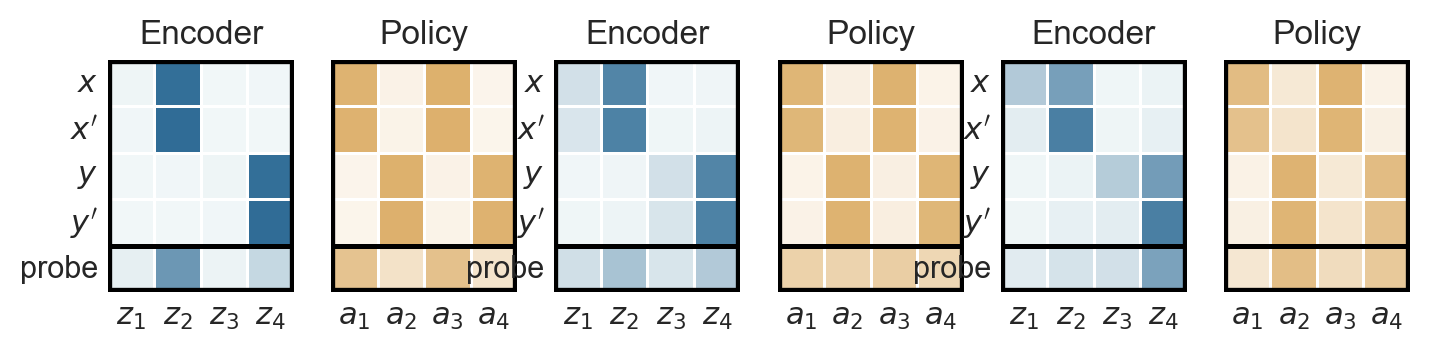

In [7]:
sim_Probe(data_set, 'ecPG_fea_sim', block_types=['cons', 'cont', 'conf'])
if to_pdf: plt.savefig(f'../figures/{data_set}/Fig6D_probPolicy_RDPG.pdf', dpi=dpi)